# Crash look at UK road traffic accident data

In [1]:
# Imports
# Data Processing
from time import time
import numpy as np
import pandas as pd

# Modelling
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

# Visualisation Packages
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px

## Read up the data

In [2]:
# Read up accidents
accidents_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2019.zip",low_memory=False, compression='zip')
accidents_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Accidents_2018.csv",low_memory=False)
accidents_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Accidents_2017.zip",low_memory=False, compression='zip')
accidents_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafety_Accidents_2016.zip",low_memory=False, compression='zip')
accidents_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Accidents_2015.zip",low_memory=False, compression='zip')
accidents_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Accidents_2014.zip",low_memory=False)

# Read up casualties
casualties_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Casualties_2019.zip",low_memory=False, compression='zip')
casualties_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2018.csv",low_memory=False)
casualties_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Casualties_2017.zip",low_memory=False, compression='zip')
casualties_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2016.zip",low_memory=False, compression='zip')
casualties_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Casualties_2015.zip",low_memory=False, compression='zip')
casualties_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Casualties_2014.zip",low_memory=False, compression='zip')

# Read up vehicles
vehicles_2019 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Vehicles_2019.zip",low_memory=False, compression='zip')
vehicles_2018 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2018.csv",low_memory=False)
vehicles_2017 = pd.read_csv(r"http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2017.zip",low_memory=False, compression='zip')
vehicles_2016 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2016.zip",low_memory=False, compression='zip')
vehicles_2015 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_Vehicles_2015.zip",low_memory=False, compression='zip')
vehicles_2014 = pd.read_csv(r"http://data.dft.gov.uk/road-accidents-safety-data/DfTRoadSafety_Vehicles_2014.zip",low_memory=False, compression='zip')

In [3]:
# Create a single dataframe
df_accidents = accidents_2019.append([accidents_2018, accidents_2017, accidents_2016, accidents_2015], sort=False)
df_vehicles = vehicles_2019.append([vehicles_2018, vehicles_2017, vehicles_2016, vehicles_2015], sort=False)
df_casualties = casualties_2019.append([casualties_2018, casualties_2017, casualties_2016, casualties_2015], sort=False)

In [4]:
print(len(df_accidents))
df_accidents.head(3)

646830


,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,18/02/2019,...,0,5,1,1,1,0,0,1,3,E01004762
1,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,15/01/2019,...,-1,-1,4,1,1,0,0,1,3,E01003117
2,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,01/01/2019,...,0,0,4,1,1,0,0,1,1,E01000943


In [5]:
print(len(df_vehicles))
df_vehicles.head(3)

1192061


,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
0,2019010128300,1,9,0,-1,-1,-1,-1,-1,-1,...,6,1,58,9,-1,-1,-1,2,1,2
1,2019010128300,2,9,0,-1,-1,-1,-1,-1,-1,...,6,3,-1,-1,-1,-1,-1,2,1,2
2,2019010152270,1,9,0,18,-1,0,-1,-1,-1,...,6,2,24,5,-1,-1,-1,3,1,3


In [6]:
print(len(df_casualties))
df_casualties.head(3)

852321


,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2019010128300,1,1,1,1,58,9,3,0,0,0,0,0,9,1,2
1,2019010128300,1,2,2,2,-1,-1,3,0,0,1,0,0,9,1,5
2,2019010128300,1,3,2,2,-1,-1,3,0,0,2,0,0,9,1,5


## Clean the data
 - Keep columns needed
 - Convert date to DateTime
 - check the number of missing or "out of range values"
 - Convert the default encoding to Pandas Categorical type

In [7]:
def ToCategorical(df, col_name_list, category_dict_list):
    '''
    Converts the given columns to categorical data type with the correct categories
    used from the category_dict_list
    
    Parameters:
    df (Pandas DataFrame): Input dataframe with columns to convert to categorical type
    col_name_list  (list): List of column names from df. These columns will be converted
    category_dict_list (list): a list of dictionaries. each dictioanry corresponds to the respective column
       and holds the correct category names to use.

    Returns:
    DataFrame with categorical columns 
    '''
    
    df_out = df.copy()
    
    for i,col in enumerate(col_name_list):
        df_out[col] = df_out[col].astype('category')
        df_out[col].cat.categories = [category_dict_list[i][j] for j in df_out[col].cat.categories]
        
    return df_out

In [8]:
# Keep columns used, remove other columns
accident_cols_to_keep= ['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
                        'Longitude', 'Latitude','Date',
                        'Light_Conditions','Weather_Conditions', 'Road_Surface_Conditions']

vehicle_cols_to_keep = ['Accident_Index', 'Vehicle_Reference', 'Age_of_Driver', 'Sex_of_Driver']

casuality_cols_to_keep = ['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference',
                          'Casualty_Severity']


df_accidents = df_accidents[accident_cols_to_keep].copy()
df_vehicles = df_vehicles[vehicle_cols_to_keep].copy()
df_casualties = df_casualties[casuality_cols_to_keep].copy()

In [9]:
# convert Date to DateTime object (Time is missing from ~100 accidents)
print('Number of null values in Date column: ' + str(len(df_accidents[df_accidents[["Date"]].isnull().any(axis=1)])))
df_accidents["Date"] = pd.DatetimeIndex(df_accidents["Date"], dayfirst=True)
df_accidents["Year"] = df_accidents["Date"].dt.year.astype('Int16')

Number of null values in Date column: 0


In [10]:
# Map categories
gender_dict = {1:'Male',2:'Female', 3:'Not known', -1:'Data missing or out of range'}
light_dict = {1:'Daylight',4:'Darkness - lights lit',5:'Darkness - lights unlit',6:'Darkness - no lighting',7:'Darkness - lighting unknown',-1:'Data missing or out of range'}
weather_dict ={1:'Fine no high winds',2:'Raining no high winds',3:'Snowing no high winds',4:'Fine + high winds',5:'Raining + high winds',6:'Snowing + high winds',7:'Fog or mist',8:'Other',9:'Unknown',-1:'Data missing or out of range'}
surface_dict = {1:'Dry',2:'Wet or damp',3:'Snow',4:'Frost or ice',5:'Flood over 3cm. deep',6:'Oil or diesel',7:'Mud',-1:'Data missing or out of range'}
severity_dict = {1:'Fatal',2:'Serious',3:'Slight'}

df_accidents = ToCategorical(df_accidents,
                             ['Light_Conditions','Weather_Conditions','Road_Surface_Conditions'],
                             [light_dict,weather_dict,surface_dict])

df_vehicles = ToCategorical(df_vehicles, ['Sex_of_Driver'], [gender_dict])
df_casualties = ToCategorical(df_casualties, ['Casualty_Severity'], [severity_dict])


In [60]:
# Check the number of missing values

def CheckNulls(df, df_name='DataFrame'):
    '''
    Function that checks the number of rows with any missing values
    Input:
    df: DataFrame to check
    df_name: str, name to use as DF name in the returned prints
    
    Returns: Null, printing the numbor missig rows to the screen
    '''
    print('\n'+df_name)
    # Total number of Accident Table
    print(f'Number of rows in {df_name}: \t{len(df)}')

    # Numeric columns
    print(f'Number of numerical rows with any missing values in {df_name}: {df.isnull().any(axis=1).sum()}')
    cols_w_null = df.columns[df.isnull().any()].to_list()
    print(f'Numeric columns with nulls: {cols_w_null}')
    
    # Categoorical columns
    missing_cat_rows = df.isin(['Data missing or out of range','Unknown']).any(axis=1).sum()
    print(f'Number of categorical rows with any missing values in {df_name}: {missing_cat_rows}')


In [62]:
# Accidents
CheckNulls(df_accidents, 'df_accidents')
CheckNulls(df_vehicles, 'df_vehicles')
CheckNulls(df_casualties, 'df_casualties')


df_accidents
Number of rows in df_accidents: 	646684
Number of numerical rows with any missing values in df_accidents: 0
Numeric columns with nulls: []
Number of categorical rows with any missing values in df_accidents: 19450

df_vehicles
Number of rows in df_vehicles: 	1192061
Number of numerical rows with any missing values in df_vehicles: 0
Numeric columns with nulls: []
Number of categorical rows with any missing values in df_vehicles: 67

df_casualties
Number of rows in df_casualties: 	852321
Number of numerical rows with any missing values in df_casualties: 0
Numeric columns with nulls: []
Number of categorical rows with any missing values in df_casualties: 0


<div class="alert alert-block alert-info">

<b>Note:</b> Although the number of rows with missing values seems negligible compared to the total sample size, they will be dealt with on a case-by-case basis, removing the missing values based on the columns used for the analysis only.<br>
    E.g. We can still use rows for finding hot spots if driver age is not recorded (but coordinates are available). </div>

## 1. Is transport becoming safer?

In [68]:
# Merge Date to casualities
df_casualties_date = df_casualties.merge(df_accidents[["Accident_Index","Year"]], left_on="Accident_Index",right_on="Accident_Index",how='left')

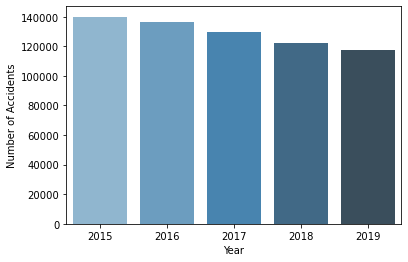

In [69]:
# Count accidents by year
df_accidents_by_year = df_accidents["Year"].value_counts()

# Plot
ax = sns.barplot(y=df_accidents_by_year.values, x=df_accidents_by_year.index, palette="Blues_d")
ax.set(xlabel="Year", ylabel = "Number of Accidents");

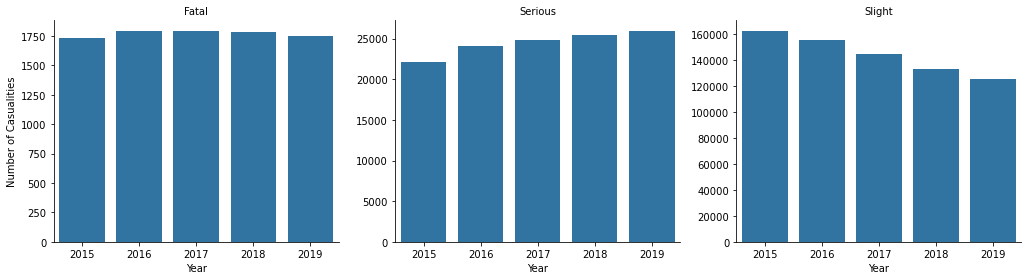

In [70]:
# How does the number of casualities change
df_casualties_by_year = df_casualties_date.groupby(by=['Casualty_Severity','Year'], as_index=False)['Accident_Index'].count()

g = sns.FacetGrid(df_casualties_by_year, col="Casualty_Severity", sharey=False, height=4,
    aspect=1.2,)
g.map(sns.barplot, "Year", "Accident_Index", order=[2015,2016,2017,2018,2019])
g.set_axis_labels(y_var='Number of Casualities')
g.set_titles(col_template = '{col_name}');

## 2. Are young drivers involved in more accidents?

In [ ]:
# Drop records with missing age of driver
df_vehicles_age = df_vehicles[df_vehicles['Age_of_Driver']>0]

In [ ]:
sns.set(font_scale=1.1)
sns.set_style("white")
fig = sns.displot(df_vehicles_age, x='Age_of_Driver', kind='hist', bins=list(range(0,110,5)), kde=True,
              height=4, aspect=2)
fig.set(xlim=(0, 110), xlabel=('Age'), xticks=list(range(0,110,10)))


## 3. Are female drivers involved in more accidents then men?

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/905926/nts0206.ods

In [ ]:
# Drop missing or unkown values
df_vehicles_age_gender = df_vehicles_age[df_vehicles_age['Sex_of_Driver'].isin(['Male', 'Female'])]
df_vehicles_age_gender['Sex_of_Driver'].cat.remove_unused_categories(inplace=True)

df_vehicles_age_gender['Sex_of_Driver'].value_counts()

In [ ]:
# Create Plot
fig = sns.catplot(x="Sex_of_Driver", kind="count", data=df_vehicles_age_gender)
fig.set_xlabels('Gender of Driver') # , fontsize=12

In [ ]:
fig = sns.displot(df_vehicles_age_gender, x='Age_of_Driver', hue='Sex_of_Driver',
                  kind='hist', bins=list(range(0,110,5)), kde=True, height=4, aspect=2)
fig.set(xlim=(0, 110), xlabel=('Age'), xticks=list(range(0,110,10)))

## 3a are any vehicles types more dangerous?

## 3b Are certain road types more dangerous?

In [ ]:
#Create a heatmap, one axis will be speed limit,other roadtypes, the values will be KSI

## 4. Are injuries more severe in certain weather conditions?

In [ ]:
# Merge Accident condition columns to Casuality severities
condition_cols = ['Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions']
df_casualties_conditions = df_casualties.merge(df_accidents[['Accident_Index'] + condition_cols], on='Accident_Index', how='left')

In [ ]:
# drop missing values
print(len(df_casualties_conditions))
df_casualties_conditions = df_casualties_conditions[~(df_casualties_conditions[condition_cols].isin(['Data missing or out of range','Unkown']).any(axis=1))].copy()
print(len(df_casualties_conditions))

In [ ]:
# Calculate Killed and severly injured casulty proportions
df_ksi_counts = df_casualties_conditions.value_counts(subset=condition_cols+['Casualty_Severity']).unstack()
df_ksi_props = df_ksi_counts[['Fatal', 'Serious']].sum(1) / df_ksi_counts.sum(axis=1)

df_ksi_props = df_ksi_props.to_frame().reset_index()
df_ksi_props.rename(columns={0:'KSI'}, inplace=True)
df_ksi_props = df_ksi_props.sort_values(by='KSI', ascending=False).reset_index(drop=True)
df_ksi_props.head()

In [ ]:
df_ksi_props['label'] = df_ksi_props[condition_cols].astype('str').agg('; '.join, axis=1)

In [ ]:
plt.bar(height=df_ksi_props['KSI'], x=df_ksi_props.index, linewidth=0, width=1.0)

# add the mean as a horisontal line and std as dotted.

In [ ]:
std = df_ksi_props.loc[df_ksi_props['KSI']>0, 'KSI'].describe()['std']
mean =df_ksi_props.loc[df_ksi_props['KSI']>0, 'KSI'].describe()['mean']
df_ksi_props_high = df_ksi_props[df_ksi_props['KSI']>=(mean+std)]

plt.bar(height=df_ksi_props_high['KSI'], x=df_ksi_props_high['label'] , linewidth=0, width=1.0)

In [ ]:
mean, std

In [ ]:
df_ksi_props_encoded = df_ksi_props.copy()

for col in condition_cols:
    df_ksi_props_encoded[col] = df_ksi_props[col].cat.codes
    
df_ksi_props_encoded.head()

In [ ]:
fig = px.parallel_coordinates(df_ksi_props_encoded,
                              color="KSI",
                              dimensions=
                              ['Light_Conditions','Weather_Conditions',
                               'Road_Surface_Conditions','KSI'
                              ],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=0.25)
fig.show()

In [ ]:
light_dict

In [ ]:
df_ksi_props_encoded = ['KSI'].hist()

In [ ]:
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4','0.4-0.5','0.5+']
df_ksi_props['KSI_binned'] = pd.cut(df_ksi_props['KSI'], bins, include_lowest=True, labels=labels)

df_ksi_props.head()

In [ ]:
fig = px.parallel_categories(df_ksi_props, dimensions=condition_cols + ['KSI_binned'],
                             color="KSI",
                             color_continuous_scale=px.colors.sequential.Inferno,
                             #labels={'sex':'Payer sex', 'smoker':'Smokers at the table', 'day':'Day of week'}
                            )
fig.show()

In [ ]:
import plotly.graph_objects as go

df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/parcoords_data.csv")

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = df['colorVal'],
                   colorscale = 'Electric',
                   showscale = True,
                   cmin = -4000,
                   cmax = -100),
        dimensions = list([
            dict(range = [32000,227900],
                 constraintrange = [100000,150000],
                 label = "Block Height", values = df['blockHeight']),
            dict(range = [0,700000],
                 label = 'Block Width', values = df['blockWidth']),
            dict(tickvals = [0,0.5,1,2,3],
                 ticktext = ['A','AB','B','Y','Z'],
                 label = 'Cyclinder Material', values = df['cycMaterial']),
            dict(range = [-1,4],
                 tickvals = [0,1,2,3],
                 label = 'Block Material', values = df['blockMaterial']),
            dict(range = [134,3154],
                 visible = True,
                 label = 'Total Weight', values = df['totalWeight']),
            dict(range = [9,19984],
                 label = 'Assembly Penalty Wt', values = df['assemblyPW']),
            dict(range = [49000,568000],
                 label = 'Height st Width', values = df['HstW'])])
    )
)
fig.show()

In [ ]:
df

## https://datavizcatalogue.com/methods/parallel_coordinates.html

# https://towardsdatascience.com/parallel-coordinates-plots-6fcfa066dcb3

https://dataforvisualization.com/charts/parallel-sets-plot/#:~:text=Definition,higher%20value%20of%20that%20category.



In [ ]:
df_ksi_props[df_ksi_props['KSI']>0.3]

In [ ]:
sns.set(font_scale=0.9)
df_light_weather = df_ksi_props[df_ksi_props['Road_Surface_Conditions'].isnull()].pivot(values='KSI',
                   index='Light_Conditions',
                   columns='Weather_Conditions')

sns.heatmap(df_light_weather, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

In [ ]:
df_light_surface = df_ksi_props[df_ksi_props['Weather_Conditions'].isnull()].pivot(values='KSI',
                   index='Light_Conditions',
                   columns='Road_Surface_Conditions')

sns.heatmap(df_light_surface, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

In [ ]:
df_weather_surface = df_ksi_props[df_ksi_props['Light_Conditions'].isnull()].pivot(values='KSI',
                   index='Weather_Conditions',
                   columns='Road_Surface_Conditions')

sns.heatmap(df_weather_surface, annot=True, cmap="YlGnBu", vmin=0, vmax=1);

## 5. can we find the worst accident hot spot locations?

https://towardsdatascience.com/how-to-embed-interactive-charts-on-your-medium-articles-and-website-6987f7b28472#:~:text=Embed%20in%20Medium&text=Using%20Datapane's%20API%2C%20you%20can,and%20embed%20it%20into%20Medium.&text=Once%20you%20have%20logged%20in,single%20Plot%20component%20in%20it.
https://andrewpwheeler.com/2015/09/03/using-kdtrees-in-python-to-calculate-neighbor-counts/

https://towardsdatascience.com/mapping-the-uks-traffic-accident-hotspots-632b1129057b

In [ ]:
# Merge Coordinates to casualities
casuality_cols = ['Accident_Index','Vehicle_Reference','Casualty_Reference','Casualty_Severity']
df_casualties_coords = df_casualties[casuality_cols].merge(df_accidents, on='Accident_Index', how='left')
df_casualties_coords = ToCategorical(df_casualties_coords, ['Casualty_Severity'], [severity])

# Drop Slight Injuries
print(len(df_casualties_coords))
df_casualties_coords = df_casualties_coords[~(df_casualties_coords['Casualty_Severity']=='Slight')].copy()

# Drop missing coordinates
print(len(df_casualties_coords))
df_casualties_coords = df_casualties_coords[~df_casualties_coords[['Location_Easting_OSGR','Location_Northing_OSGR']].isnull().any(axis=1)]

# Convert DataFrame to array
print(len(df_casualties_coords))
casuality_array = df_casualties_coords.values

# get the coordinates only
X = np.array(casuality_array[:,4:6], dtype='int32')

# Plot points for a visual checks
sns.scatterplot(x=X[:,0], y=X[:,1])
plt.axis('equal');

### Optimum eps

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]


plt.plot(distances)

In [ ]:
print(distances.shape)
distances_filter = distances[distances<500]
print(distances_filter.shape)
plt.plot(distances_filter)

In [ ]:
print(distances.shape)
distances_filter = distances[distances<100]
print(distances_filter.shape)
plt.plot(distances_filter)

In [ ]:
print(distances.shape)
distances_filter = distances[distances<50]
print(distances_filter.shape)
plt.plot(distances_filter)

### Set up DBSCAN

Run multiple set of model fitting

for accidents with 500k points it took approx ~ 12 minutes

using only KSI (Killed and Seriously Injured Casuality), we have 131,355 points and it takes ~2min

In [ ]:
# get relative density accidents/sqm
start_time=time()

df_cluster_stats = pd.DataFrame(columns=['eps', 'min_samples', 'No of Clusters', 'Max Number of accidents', 'Max Density', 'Radius', 'Location_Easting_OSGR', 'Location_Northing_OSGR'])
cnt=0

for eps in range(5,51,5):
    for min_sample in range(5,61,1):
                
        # Run DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_sample, n_jobs=12).fit(X)
        labels = db.labels_
        no_clusters = len(np.unique(labels))
        
        # Check if we have no Clusters
        if no_clusters==1:
            max_acc_no = np.nan
            max_density = np.nan
            coords = [np.nan, np.nan]
        
        else:
            # merge cluster labels back
            df_casualties_coords['Cluster No'] = labels
            df_accidents_coords_complete_cluster = df_casualties_coords[df_casualties_coords['Cluster No']>(-1)].copy()
    
            max_acc_no = df_accidents_coords_complete_cluster['Cluster No'].value_counts().max()
            max_clus_no = df_accidents_coords_complete_cluster['Cluster No'].value_counts().idxmax()
            # get the centroid coordinates
            df_cluster_centroid = df_accidents_coords_complete_cluster.groupby(by=['Cluster No'])[['Location_Easting_OSGR','Location_Northing_OSGR']].mean()
    
            # get estimated density using circle           
            xy_max = df_accidents_coords_complete_cluster.groupby(by=['Cluster No'])[['Location_Easting_OSGR','Location_Northing_OSGR']].max()
            xy_min = df_accidents_coords_complete_cluster.groupby(by=['Cluster No'])[['Location_Easting_OSGR','Location_Northing_OSGR']].min()
            xy_delta = ((xy_max - xy_min)/2)**2
            
            # Populate centroid list DF
            df_cluster_centroid['No of Accidents'] = df_accidents_coords_complete_cluster['Cluster No'].value_counts()
            
            # Increase the radius by eps/2 assuming conservatively a boundary
            df_cluster_centroid['Radius'] = np.sqrt(xy_delta.sum(axis=1)) + eps/2
            df_cluster_centroid['Area'] = np.pi * df_cluster_centroid['Radius']**2
            df_cluster_centroid['Density'] = df_cluster_centroid['No of Accidents']/df_cluster_centroid['Area'] 
            df_cluster_centroid['eps'] = eps
            df_cluster_centroid['min_samples'] = min_sample
            
            df_cluster_centroid.replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Cluster with max density
            idx_max = df_cluster_centroid['Density'].idxmax()
            max_density = df_cluster_centroid['Density'].max()
            radius = df_cluster_centroid.loc[idx_max]['Radius']
            
            # Cordinates of Cluster
            coords = df_cluster_centroid.values[idx_max]
            
        
        # Populate output
        df_cluster_stats.loc[cnt, :] = [eps, min_sample, no_clusters, max_acc_no, max_density,radius,coords[0],coords[1]]
        if cnt==0:
            df_cluster_list = df_cluster_centroid.copy()
        else:
            df_cluster_list = df_cluster_list.append(df_cluster_centroid)
            
        cnt+=1
        
elapsed_time = time() - start_time
print('Clustering took: {:.2f} minutes'.format(elapsed_time/60))

In [ ]:
df_cluster_stats_clean = df_cluster_stats[df_cluster_stats['No of Clusters']>1]

df_cluster_stats_clean.sort_values(by=['Max Number of accidents'], ascending=False)
df_cluster_stats_clean.sort_values(by=['Max Density'], ascending=False).head(20)
# df_cluster_stats_clean.sort_values(by=['Radius'], ascending=False).head(20)

In [ ]:
df_cluster_list.sort_values(by='No of Accidents', ascending=False).head(20)

In [ ]:
sns.scatterplot(x=df_cluster_list['Location_Easting_OSGR'], y=df_cluster_list['Location_Northing_OSGR'])
plt.axis('equal');

In [ ]:
# sns.relplot(x="Radius", y="No of Accidents", size='min_samples', sizes=(15, 200), data=df_cluster_list);

sns.relplot(x="eps", y="Radius",
#             hue="eps",
#             size="Density",
            sizes=(40, 400), alpha=.5, palette='mako_r',
            height=6, data=df_cluster_list)

sns.relplot(x="eps", y="Density",
#             hue="eps",
#             size="Density",
            sizes=(40, 400), alpha=.5, palette='mako_r',
            height=6, data=df_cluster_list)

In [ ]:
df_cluster_list.sort_values(by='No of Accidents',ascending=False).head()

## Look at the location with highest point counts

In [ ]:
db = DBSCAN(eps=50, min_samples=5, n_jobs=12).fit(X)
labels = db.labels_
df_casualties_coords['Cluster No'] = labels

In [ ]:
df_accidents_to_check = df_casualties_coords[df_casualties_coords['Cluster No']==403]

In [ ]:
df_accidents_to_check = df_accidents_to_check.merge(df_accidents[['Accident_Index','Latitude','Longitude']],
                                                    on='Accident_Index', how='left')

In [ ]:
df_accidents_to_check[['Location_Easting_OSGR', 'Location_Northing_OSGR']].mean()

In [ ]:
fig = px.scatter_mapbox(df_accidents_to_check, lat="Latitude", lon="Longitude",
                        hover_name="Cluster No",
                        hover_data=["Accident_Severity", "Number_of_Casualties",'Year'],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Look at the location with highest density

In [ ]:
df_cluster_list.sort_values(by='Density',ascending=False).head()

In [ ]:
db = DBSCAN(eps=5, min_samples=13, n_jobs=12).fit(X)
labels = db.labels_
df_casualties_coords['Cluster No'] = labels

In [ ]:
df_accidents_to_check = df_casualties_coords[df_casualties_coords['Cluster No']==3].copy()

df_accidents_to_check = df_accidents_to_check.merge(df_accidents[['Accident_Index','Latitude','Longitude']],
                                                    on='Accident_Index', how='left')

df_accidents_to_check[['Location_Easting_OSGR', 'Location_Northing_OSGR']].mean()

In [ ]:
np.random.randn(3)/1000

In [ ]:
jitter_x = np.random.rand(len(df_accidents_to_check))/1000
jitter_y = np.random.rand(len(df_accidents_to_check))/1000

df_accidents_to_check["Latitude_x"] = df_accidents_to_check["Latitude_x"]+jitter_x
df_accidents_to_check["Longitude_x"] = df_accidents_to_check["Longitude_x"]+jitter_y

In [ ]:
fig = px.scatter_mapbox(df_accidents_to_check, lat="Latitude_x", lon="Longitude_x",
                        hover_name="Cluster No",
                        hover_data=["Accident_Severity", "Number_of_Casualties",'Year'],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

df_accident_clusters.head()

## Try KDE

In [ ]:
# KDTRee
accident_tree = KDTree(accident_array[:,1:3])

rank_cols = []

for dist in range(50,215,15):
    df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist)+ 'm'] = accident_tree.query_radius(accident_array[:,1:3],
                                                                                   r=dist,
                                                                                   count_only=True)
    
    df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist) + 'm rank'] = df_accidents_coords_complete.loc[:,'Neighbour ' + str(dist)+ 'm'].rank(ascending=False)
    
    rank_cols.append('Neighbour ' + str(dist) + 'm rank')
#     df_accidents_coords_complete.sort_values(by='NeighbourNO', ascending=False).reset_index()[:20]

In [ ]:
df_accidents_coords_complete['Av Rank'] = df_accidents_coords_complete[rank_cols].mean(axis=1)

In [ ]:
df_accidents_coords_complete.sort_values(by=['Av Rank'], ascending=True).head()

## Try Optics

In [ ]:
start_time = time()
optics_clustering = OPTICS(min_samples=40, max_eps=25, metric='euclidean', n_jobs=8).fit(X)

end_time = time()
print((end_time-start_time))

In [ ]:
optics_labels = optics_clustering.labels_
print(len(np.unique(optics_labels)))

df_accidents_coords_complete['OPTICS Cluster No'] = optics_labels

df_accidents = df_accidents.merge(df_accidents_coords_complete[['Accident_Index', 'OPTICS Cluster No']],
                                  left_on='Accident_Index', right_on='Accident_Index', how='left')

In [ ]:
df_accidents.head()

In [ ]:
df_accident_clusters = df_accidents[df_accidents['OPTICS Cluster No_y']>-1].copy()
len(df_accident_clusters)

In [ ]:
fig = px.scatter_mapbox(df_accident_clusters, lat="Latitude", lon="Longitude",
                        hover_name='OPTICS Cluster No_y', hover_data=["Accident_Severity", "Number_of_Casualties"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Can we estimate the number of casualities and respective severity?

A witness would know:
- Location
- type of Vehicles
- Date/time
- Surface conditions

Out of those what would be relevant?

What are we trying to estimate?
<br>
number of casualities with severity?
get a single estimation with a vector of 3 elements: number of slight, serious, fatal
 - Multivariate Linear Regression
 - ## Let's use ANN

- Veh Leaving Carriageway

<br>get a model for each vehicle?

In [ ]:
accident_features = ['Accident_Index','Road_Type','Speed_limit','Junction_Detail','Junction_Control',
                     'Light_Conditions','Weather_Conditions','Road_Surface_Conditions','Urban_or_Rural_Area']

vehicle_features = ['Vehicle_Type']
# Veh Leaving Carriageway

In [ ]:
df_vehicle_classes = df_vehicles.groupby(['Accident_Index','Vehicle_Type']).size().unstack(fill_value=0)
print(len(df_vehicle_classes))

In [ ]:
casaualty_severity = df_casualties.groupby(['Accident_Index','Casualty_Severity']).size().unstack(fill_value=0)
casaualty_severity.rename(columns={1: "Fatal", 2: "Serious", 3: "Slight"}, inplace=True)
casaualty_severity.head()

In [ ]:
print(len(df_accidents[accident_features]))
df_accidents_s1 = df_accidents[accident_features].merge(df_vehicle_classes, on="Accident_Index")
df_accidents_s2 = df_accidents_s1.merge(casaualty_severity, on="Accident_Index")

In [ ]:
# simply drop NA
df_accidents_s3 = df_accidents_s2.drop(df_accidents_s2[df_accidents_s2.isnull().any(1)].index)

# simply drop negatives:
value_cols = ['Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
 'Urban_or_Rural_Area', -1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98, 'Fatal',
 'Serious', 'Slight']

df_accidents_s3.loc[df_accidents_s3['Junction_Control']==-1, 'Junction_Control'] = 5
df_accidents_s3.loc[df_accidents_s3['Junction_Detail']==-1, 'Junction_Detail'] = 10
df_accidents_s3.loc[df_accidents_s3['Road_Surface_Conditions']==-1, 'Road_Surface_Conditions'] = 8

df_accidents_s3.loc[df_accidents_s3['Light_Conditions']==-1, 'Light_Conditions'] = 8
df_accidents_s3.loc[df_accidents_s3['Weather_Conditions']==-1, 'Weather_Conditions'] = 9

df_accidents_s3.loc[df_accidents_s3['Road_Type']==-1, 'Road_Type'] = 9
df_accidents_s3.loc[df_accidents_s3['Urban_or_Rural_Area']==-1, 'Urban_or_Rural_Area'] = 3

In [ ]:
df_accidents_s3[(df_accidents_s3[value_cols] < 0).any(1)]

In [ ]:
x_cont_cols = ['Speed_limit', -1, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98]

x_cat_cols = ['Road_Type', 'Junction_Detail', 'Junction_Control', 'Light_Conditions',
              'Weather_Conditions', 'Road_Surface_Conditions', 'Urban_or_Rural_Area']

label_cols = ['Fatal', 'Serious', 'Slight']

In [ ]:
X = torch.tensor(df_accidents_s3[x_cont_cols + x_cat_cols].values, dtype=torch.float)
x_cont = torch.tensor(df_accidents_s3[x_cont_cols].values, dtype=torch.float)

df_accidents_s3[x_cat_cols] = df_accidents_s3[x_cat_cols].astype("category")
x_cat = torch.tensor( np.stack( [df_accidents_s3[col].cat.codes.values for col in x_cat_cols], axis=1), dtype=torch.int)

In [ ]:
x_cat.shape

In [ ]:
y = torch.tensor(df_accidents_s3[label_cols].values, dtype=torch.float)

## Train test split

<div class="alert alert-block alert-danger">
<b>Danger:</b> 

ADD SHUFFLING


</div>

In [ ]:
cat_train = x_cat[:batch_size-test_size]
cat_test = x_cat[batch_size-test_size:batch_size]
con_train = x_cont[:batch_size-test_size]
con_test = x_cont[batch_size-test_size:batch_size]

In [ ]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

### Setting up Model

In [ ]:
class RegressionModel(nn.Module):
    
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.35):
        
        super().__init__()
        
        # Embedding
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        
        # Dropout layer
        self.emb_drop = nn.Dropout(p)
        
        # normalise the continous data
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont
        
        # Create list of fully connected layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        # fully connected layer
        layerlist.append(nn.Linear(layers[-1], out_sz))
        
        
        self.layers = nn.Sequential(*layerlist)
        
        
    def forward(self, x_cat, x_cont):
        
        embeddings = []
                
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        # Concatenate individial vectors of categorical columns from embeddings    
        x = torch.cat(embeddings, 1)
        # Apply dropout
        x = self.emb_drop(x)
        
        # Normalise continous data
        x_cont = self.bn_cont(x_cont)
        
        # Concatenate categorical and continous columns
        x = torch.cat([x,x_cont],1)
        # Pass through tensor the fully connected layers
        x = self.layers(x)
        
        return x

In [ ]:
torch.manual_seed(42)
model = RegressionModel(emb_szs, len(x_cont_cols), 3, [200,100,60], p=0.4)

criterion = nn.MSELoss() # np.sqrt(MSE) --> RMS

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 60000
test_size = int(batch_size * 0.2)

In [ ]:
start_time = time()

epochs = 300

losses = []

for i in range(epochs):
    i+=1
    
    y_pred = model(cat_train,con_train)
    y_pred = torch.round(y_pred)
    loss = torch.sqrt(criterion(y_pred, y_train))
    
    losses.append(loss)
    
    if i%10 == 1:
        print(f'epoch: {i} loss is {loss}')
        
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
end_time = time()
duration = end_time - start_time
print(f'Traning took {duration/60} minutes')

In [ ]:
torch.round(y_pred)

In [ ]:
plt.plot(range(epochs), losses)

In [ ]:
with torch.no_grad():
    
    y_val = model(cat_test,con_test)
    
    loss = torch.sqrt(criterion(y_val, y_test))

In [ ]:
loss

In [ ]:
for i in range(10):
    
    print(f'{i}.) Predicted: {y_val[i]} TRUE: {y_test[i]}')